### Configuracion Inicial

In [1]:
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import LocalOutlierFactor

dataset = pd.read_csv("properati_argentina_2021.csv")
sns.set()

SEMILLA = 0
TEST_SIZE = 0.2


def obtener_frecuencia_relativa(series):
    frecuencia_absoluta = series.value_counts()
    frecuencia_relativa = frecuencia_absoluta / frecuencia_absoluta.sum()
    return frecuencia_relativa


def separate_date(dataset, column_name):
    dataset[f"{column_name}_year"] = dataset[column_name].str[:4].astype(int)
    dataset[f"{column_name}_month"] = dataset[column_name].str[5:7].astype(int)
    dataset[f"{column_name}_day"] = dataset[column_name].str[8:10].astype(int)
    dataset.drop([column_name], axis=1, inplace=True)


# 1. Análisis Exploratorio y Preprocesamiento de Datos


## Separación Train-Test

In [2]:
dataset_train, dataset_test = train_test_split(
    dataset, test_size=TEST_SIZE, random_state=SEMILLA
)

print("Proporción - Train: {:.2f}".format(dataset_train.shape[0] / dataset.shape[0]))
print("Proporción - Test: {:.2f}".format(dataset_test.shape[0] / dataset.shape[0]))

Proporción - Train: 0.80
Proporción - Test: 0.20


## Filtrado del set de Training

Damos un primer vistazo al dataset, para observar las columnas y sus valores

In [3]:
dataset_train.head(5)


,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
19012,f19OtftrEdr1twkOwQdmIw==,2021-01-27,2021-07-01,2021-01-27,NaN,NaN,Bs.As. G.B.A. Zona Norte,NaN,NaN,NaN,NaN,Venta,Casa,7.0,5.0,269.0,269.0,380000.0,USD,Casa - Zarate
418309,Ak3A3BAUvl8vjWRpGdMSqg==,2021-10-14,2021-11-03,2021-10-14,-34.400856,-58.649901,Bs.As. G.B.A. Zona Norte,Tigre,Nordelta,NaN,NaN,Venta,Departamento,3.0,2.0,95.0,88.0,170000.0,USD,DEPARTAMENTO VENTA ANTARES NORDELTA 3 AMBIENTE...
157888,K8U3zUGHru2nNfFhsz8ckA==,2021-05-26,2021-06-27,2021-05-26,-32.891939,-68.854564,Mendoza,Mendoza,NaN,NaN,NaN,Alquiler,Departamento,2.0,1.0,120.0,60.0,28500.0,ARS,"Alquiler DEPARTAMENTO en Ciudad, a mts Aristides"
405630,ZauA5QYZtApfKQkF5gIu+A==,2021-01-07,2021-09-03,2021-01-07,-34.895556,-57.977944,Bs.As. G.B.A. Zona Sur,La Plata,Tolosa,NaN,NaN,Venta,Casa,5.0,3.0,85.0,85.0,110000.0,USD,Duplex venta 3 dormitorios 2 baños 1 cochera 8...
147192,Cvf0fa9tdZflz/jma3g2Kw==,2021-08-19,2021-10-14,2021-08-19,-34.900083,-56.171641,Montevideo,NaN,NaN,NaN,NaN,Alquiler,Departamento,NaN,1.0,55.0,45.0,19900.0,UYU,Apartamento de 1 dormitorio en ALQUILER - Cordón


Definimos un diccionario de filtros que vamos a utilizar para filtrar nuestro dataset, y filtramos las columnas que no nos interesan. (antes de filtrarlas, normalizamos sus valores por si hay alguna discrepancia)

In [4]:
filtro_tipo_propiedad = ["casa", "ph", "departamento"]
filtro_operacion = ["venta"]
filtro_ubicacion = ["capital federal"]
filtro_moneda = ["usd"]

filtros = {
    "property_type": filtro_tipo_propiedad,
    "operation": filtro_operacion,
    "place_l2": filtro_ubicacion,
    "property_currency": filtro_moneda,
}

for columna in filtros:
    dataset_train[columna] = dataset_train[columna].str.lower()

for columna_a_filtrar, filtro in filtros.items():
    dataset_train = dataset_train[dataset_train[columna_a_filtrar].isin(filtro)]

dataset_train.shape


(75488, 20)

Observamos la composicion de datos NULL en las columnas del dataset

In [5]:
filas_totales = dataset_train.shape[0]
composicion_null = dataset_train.isna().sum() / filas_totales * 100
composicion_null.sort_values(ascending=False, inplace=True)
composicion_null


place_l6                    100.000000
place_l5                    100.000000
place_l4                     96.131836
property_bedrooms            11.532959
property_surface_total        5.129292
latitud                       3.972817
longitud                      3.972817
property_surface_covered      3.572753
property_rooms                1.092889
place_l3                      0.435831
property_currency             0.000000
property_price                0.000000
id                            0.000000
property_type                 0.000000
operation                     0.000000
start_date                    0.000000
place_l2                      0.000000
created_on                    0.000000
end_date                      0.000000
property_title                0.000000
dtype: float64

Las columnas `place_l5` y `place_l6` contienen `NaN` en todas sus filas. Ademas, `place_4` contiene `NaN` en el 96% de sus filas. Por estas razones, eliminamos las columnas.

Las columnas `id` y `property_title` no nos sirves para predecir nada, ya que son valores arbitrarios que no aportan al analisis. Por esta razon, las eliminamos tambien.

Las `property_currency`, `place_l2`, `operation` solo contienen un valor posible debido al filtrado, por esto las eliminamos


In [6]:
columnas_eliminar = [
    "property_title",
    "id",
    "place_l4",
    "place_l5",
    "place_l6",
    "property_currency",
    "operation",
    "place_l2",
]
dataset_train.drop(columnas_eliminar, axis=1, inplace=True)


`place_l3` no es un nombre muy significativo, lo renombramos a `barrio`

In [7]:
dataset_train = dataset_train.rename(columns={"place_l3": "barrio"})

Convertimos las fechas en un mejor formato para el analisis.

In [8]:

dataset_train["start_date"] = pd.to_datetime(
    dataset_train["start_date"], errors="coerce"
)
dataset_train["end_date"] = pd.to_datetime(dataset_train["end_date"], errors="coerce")
dataset_train["created_on"] = pd.to_datetime(
    dataset_train["created_on"], errors="coerce"
)



## Analisis Exploratorio

### Analisis Inicial


Observamos la estructura general del dataset


In [9]:
dataset_train.shape


(75488, 12)

In [10]:
dataset_train.dtypes


start_date                  datetime64[ns]
end_date                    datetime64[ns]
created_on                  datetime64[ns]
latitud                            float64
longitud                           float64
barrio                              object
property_type                       object
property_rooms                     float64
property_bedrooms                  float64
property_surface_total             float64
property_surface_covered           float64
property_price                     float64
dtype: object

In [11]:
dataset_train.head(5)


,start_date,end_date,created_on,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
83944,2021-02-05,2021-03-05,2021-02-05,-34.554271,-58.457668,Belgrano,departamento,2.0,1.0,59.0,59.0,178000.0
195386,2021-08-21,2021-08-24,2021-08-21,-34.613544,-58.368072,Monserrat,departamento,3.0,2.0,71.0,71.0,129000.0
293157,2021-02-23,2021-03-01,2021-02-23,-34.571020,-58.433125,Palermo,departamento,2.0,1.0,79.0,59.0,249000.0
384577,2021-09-06,2021-10-23,2021-09-06,-34.597384,-58.405139,Barrio Norte,departamento,4.0,3.0,91.0,85.0,165000.0
450142,2021-12-16,2022-02-09,2021-12-16,-34.591646,-58.418064,Palermo,departamento,1.0,NaN,37.0,32.0,105000.0


Separamos el dataset en variables cualitativas, cuantitativas, y temporales

In [12]:
columnas_cuantitativas = [
    "latitud",
    "longitud",
    "property_rooms",
    "property_bedrooms",
    "property_surface_total",
    "property_surface_covered",
    "property_price",
]
variables_cuantitativas = dataset_train[columnas_cuantitativas]
variables_cuantitativas.head()


,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
83944,-34.554271,-58.457668,2.0,1.0,59.0,59.0,178000.0
195386,-34.613544,-58.368072,3.0,2.0,71.0,71.0,129000.0
293157,-34.571020,-58.433125,2.0,1.0,79.0,59.0,249000.0
384577,-34.597384,-58.405139,4.0,3.0,91.0,85.0,165000.0
450142,-34.591646,-58.418064,1.0,NaN,37.0,32.0,105000.0


In [13]:
columnas_temporales = [
    "start_date",
    "end_date",
    "created_on",
]
variables_temporales = dataset_train[columnas_temporales]
variables_temporales.head()


,start_date,end_date,created_on
83944,2021-02-05,2021-03-05,2021-02-05
195386,2021-08-21,2021-08-24,2021-08-21
293157,2021-02-23,2021-03-01,2021-02-23
384577,2021-09-06,2021-10-23,2021-09-06
450142,2021-12-16,2022-02-09,2021-12-16


In [14]:
columnas_cualitativas = ["barrio", "property_type"]
variables_cualitativas = dataset_train[columnas_cualitativas]
variables_cualitativas.head()


,barrio,property_type
83944,Belgrano,departamento
195386,Monserrat,departamento
293157,Palermo,departamento
384577,Barrio Norte,departamento
450142,Palermo,departamento


### Variables Cuantitativas

Generamos estadisticas descriptivas para las columnas cuantitativas (medidas de resumen)

In [15]:
variables_cuantitativas.describe()


,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
count,72489.000000,72489.000000,74663.000000,66782.000000,71616.000000,72791.000000,7.548800e+04
mean,-34.591551,-58.448800,2.824130,2.014255,111.177823,89.711214,2.263084e+05
std,0.181312,0.282378,1.419647,1.126561,1069.452095,1101.207263,3.213432e+05
min,-53.788624,-71.438923,1.000000,1.000000,10.000000,1.000000,5.000000e+03
25%,-34.616027,-58.466524,2.000000,1.000000,45.000000,40.000000,9.500000e+04
50%,-34.595870,-58.438917,3.000000,2.000000,65.000000,58.000000,1.440000e+05
75%,-34.577492,-58.408846,4.000000,3.000000,105.000000,89.000000,2.380000e+05
max,-24.219827,-54.133330,40.000000,70.000000,137000.000000,217000.000000,2.140000e+07


Graficamos un mapa de correlaciones de las variables cuantitativas

<AxesSubplot:>

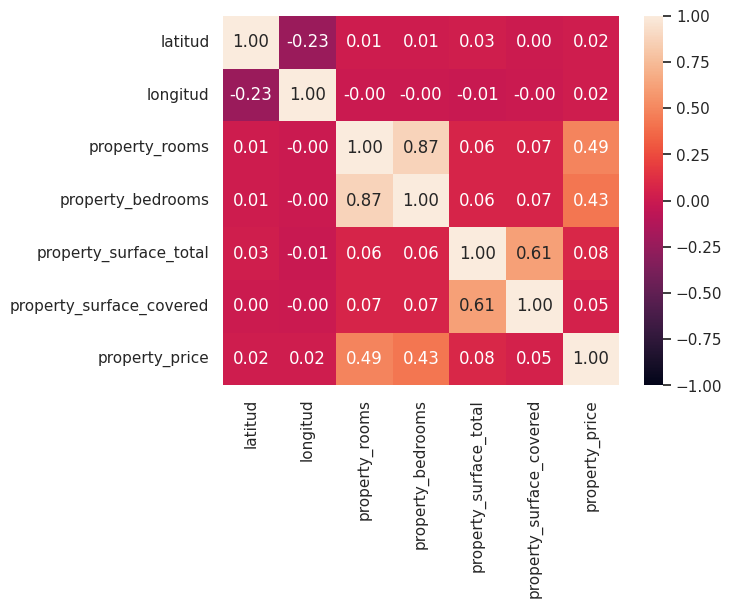

In [16]:
matriz_correlaciones = variables_cuantitativas.corr()
sns.heatmap(data=matriz_correlaciones, annot=True, fmt=".2f", vmin=-1, vmax=1)


Observamos que las variables con mas relacionadas son:
 - `property_rooms` con `property_bedrooms`
 - `property_surface_covered` con `property_surface_total`.
 - `property_price` con `property_rooms` y `property_bedrooms` (con un porcentaje mucho menor)


Realizamos graficos para observar estas relaciones.

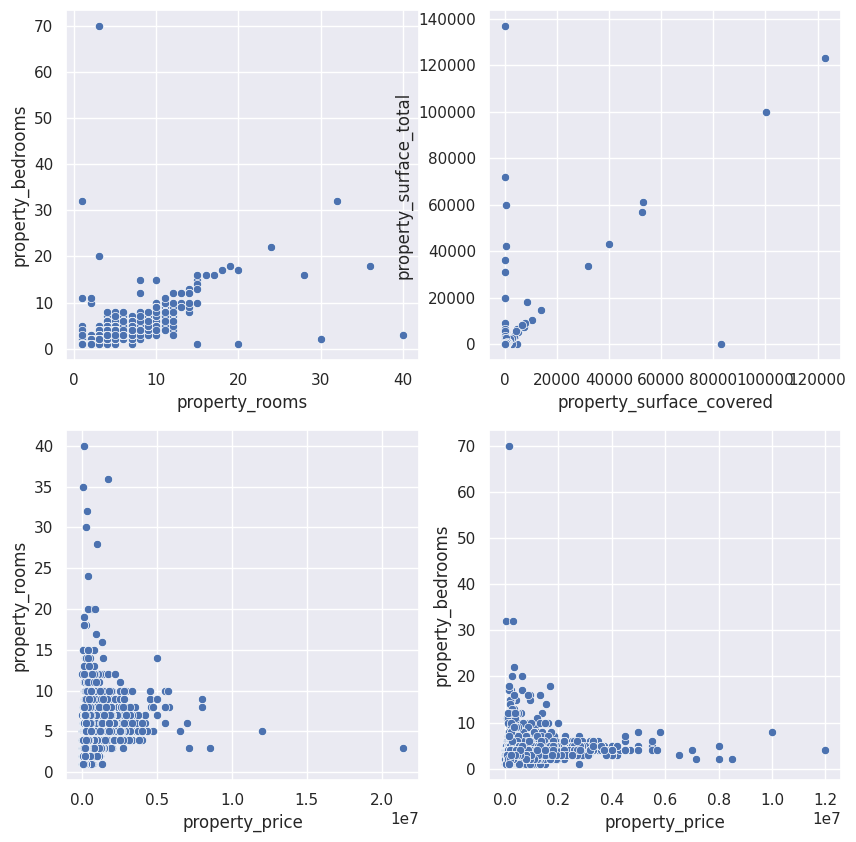

In [17]:
figs, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = np.ndarray.flatten(axes)

correlaciones = (
    ("property_rooms", "property_bedrooms"),
    ("property_surface_covered", "property_surface_total"),
    ("property_price", "property_rooms"),
    ("property_price", "property_bedrooms"),
)
for (i, correlacion) in enumerate(correlaciones):
    sns.scatterplot(ax=axes[i], data=dataset_train, x=correlacion[0], y=correlacion[1])


Vimos que hay cierta relacion lineal, pero es afectada por el alto numero de valores atipicos. Si los eliminamos rapidamente, el grafico cambia drasticamente. 

Graficamos con un _alpha_ para observar mejor la distribución

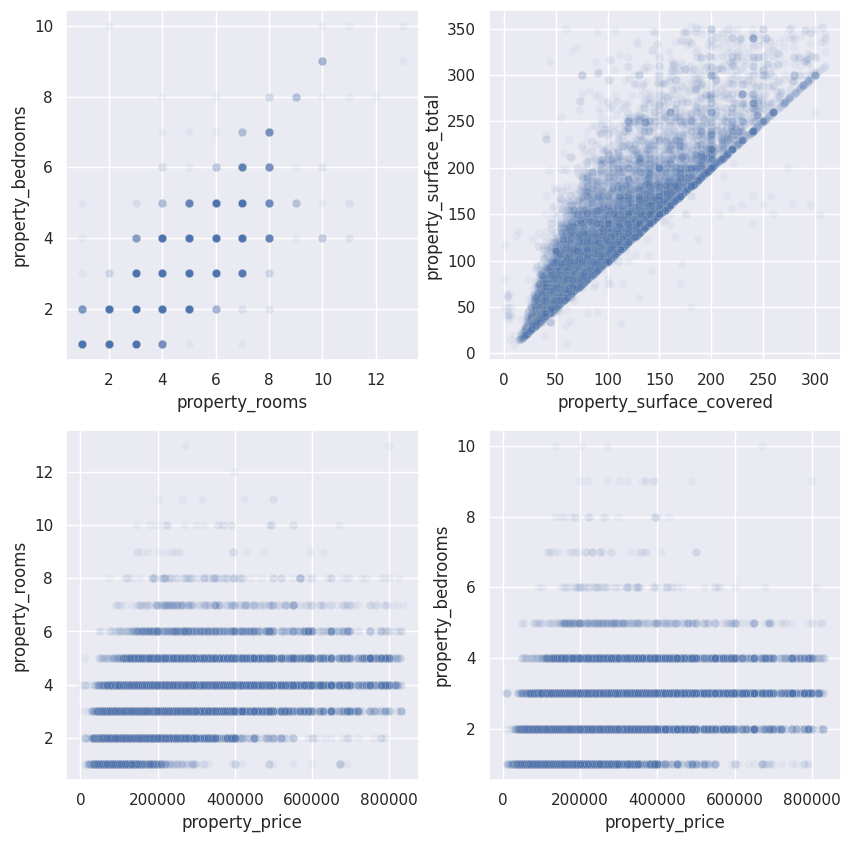

In [18]:
columnas = (
    "property_surface_covered",
    "property_surface_total",
    "property_rooms",
    "property_bedrooms",
    "property_price",
)
sin_atipicos = dataset_train.copy()
for columna in columnas:
    sin_atipicos = sin_atipicos[
        sin_atipicos[columna] < sin_atipicos[columna].quantile(0.75) * 3.5
    ]


figs, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = np.ndarray.flatten(axes)
for (i, correlacion) in enumerate(correlaciones):
    sns.scatterplot(ax=axes[i], data=sin_atipicos, x=correlacion[0], y=correlacion[1], alpha=0.05)


### Variables Cualitativas

Observamos la cantidad de valores posibles de cada variable


In [19]:
variables_cualitativas.nunique()


barrio           57
property_type     3
dtype: int64

Graficamos la distribucion de los barrios

[Text(0.5, 1.0, 'Distribucion del tipo de propiedad'),
 Text(0.5, 0, 'tipo de propiedad'),
 Text(0, 0.5, 'frecuencia')]

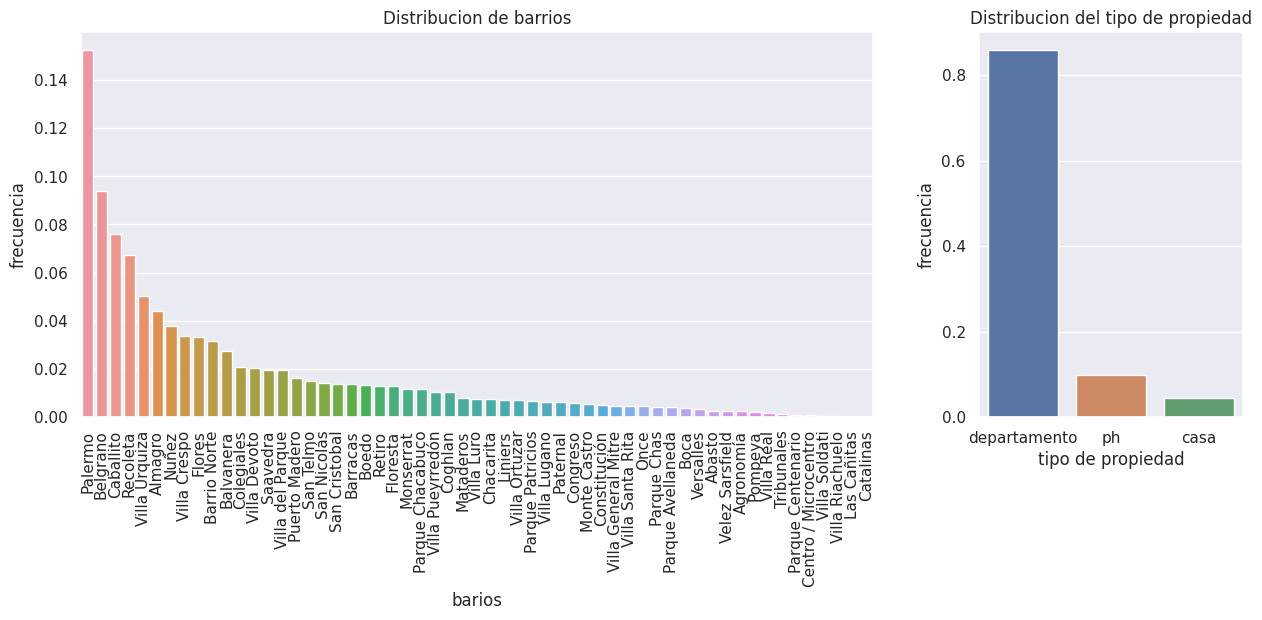

In [20]:
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(15, 5), gridspec_kw={"width_ratios": [3, 1]}
)

frecuencia_relativa = obtener_frecuencia_relativa(variables_cualitativas["barrio"])
ax = sns.barplot(ax=axes[0], x=frecuencia_relativa.index, y=frecuencia_relativa.values)
ax.set(title="Distribucion de barrios", xlabel="barios", ylabel="frecuencia")
ax.tick_params("x", labelrotation=90)

frecuencia_relativa = obtener_frecuencia_relativa(
    variables_cualitativas["property_type"]
)
ax = sns.barplot(ax=axes[1], x=frecuencia_relativa.index, y=frecuencia_relativa.values)
ax.set(
    title="Distribucion del tipo de propiedad",
    xlabel="tipo de propiedad",
    ylabel="frecuencia",
)


### Variables Temporales

Graficamos la distribución de las variables temporales


[Text(0.5, 1.0, 'Distribucion de fecha de creacion')]

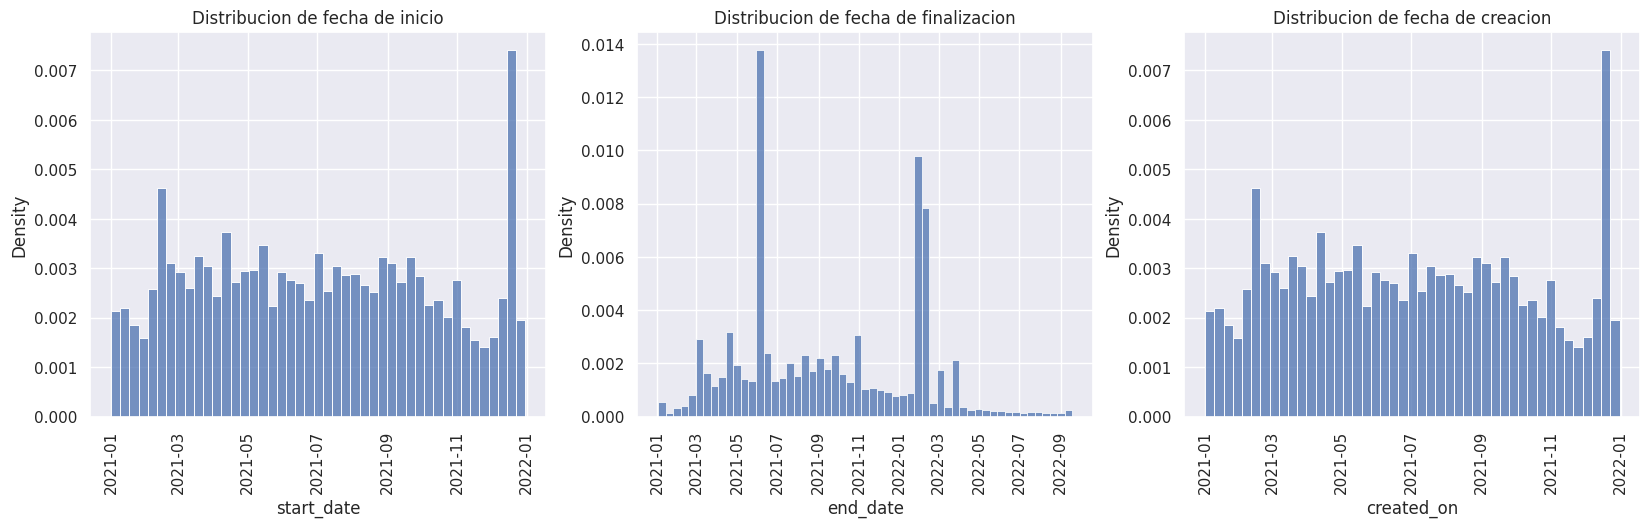

In [21]:
figs, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

for ax in axes:
    ax.tick_params("x", labelrotation=90)

sns.histplot(ax=axes[0], data=variables_temporales, x="start_date", stat="density").set(
    title="Distribucion de fecha de inicio"
)
sns.histplot(ax=axes[1], data=variables_temporales, x="end_date", stat="density").set(
    title="Distribucion de fecha de finalizacion"
)
sns.histplot(ax=axes[2], data=variables_temporales, x="created_on", stat="density").set(
    title="Distribucion de fecha de creacion"
)


Podemos eliminar `created_on`, ya que tiene distribucion practicamente identica a `start_date`

 ## Analisis de Valores Atípicos Univariados

Primero realizamos un BOXPLOT de las variables cuantitativas para observar rápidamente la distribución de OUTLIERS univariados

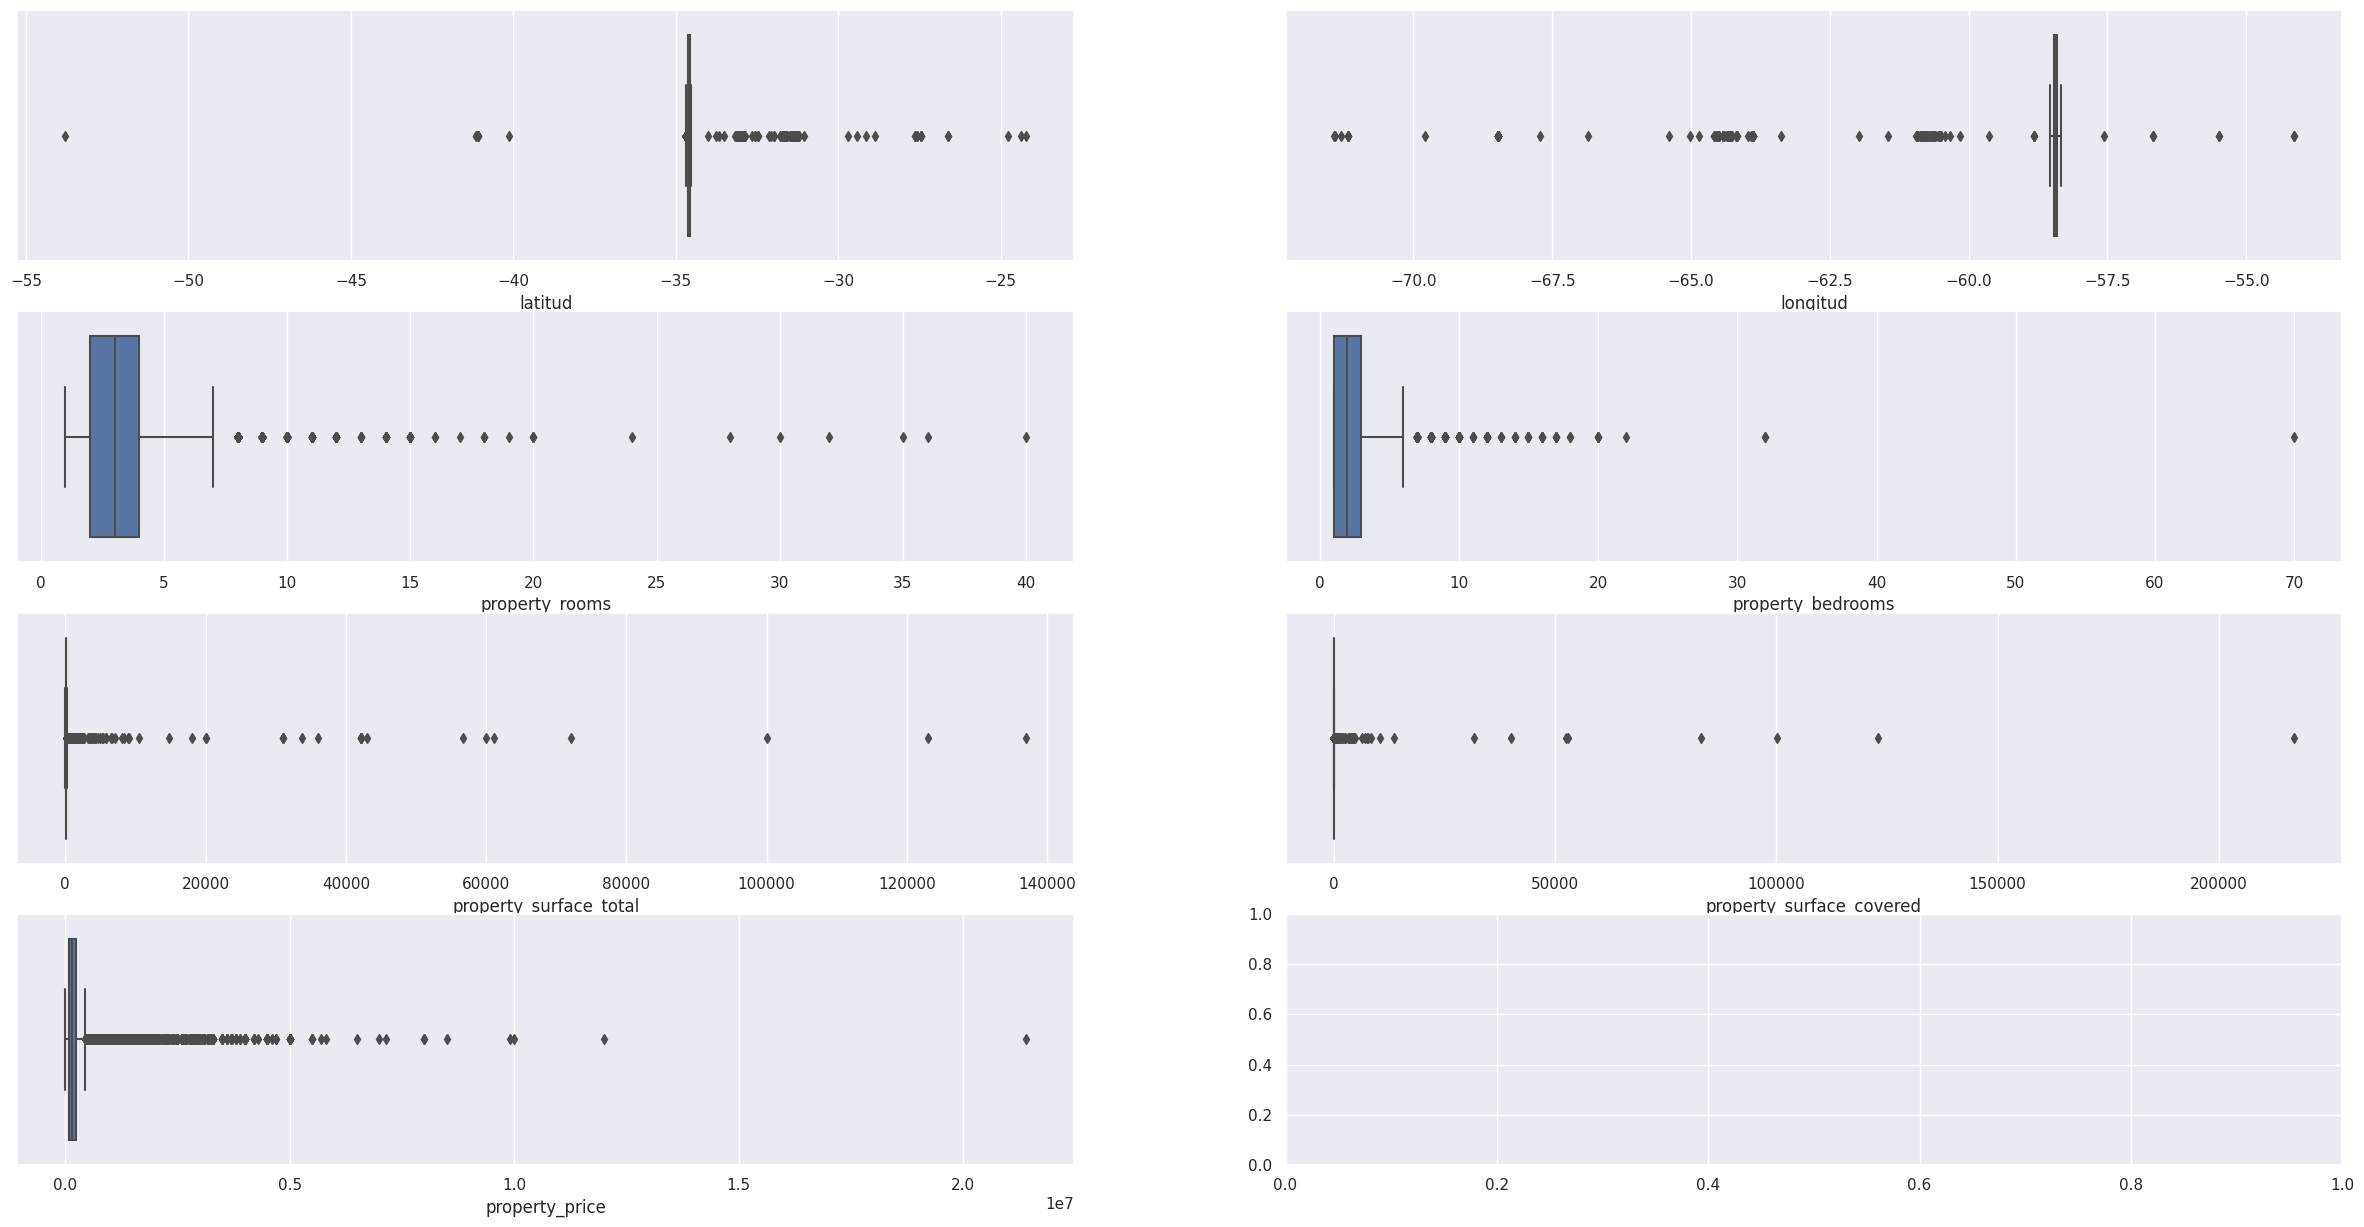

In [22]:
figs, axes = plt.subplots(nrows=4, ncols=2, figsize=(30, 15))
axes = np.ndarray.flatten(axes)
for (i, columna) in enumerate(variables_cuantitativas.columns):
    grafico=sns.boxplot(ax=axes[i], x=variables_cuantitativas[columna])
    grafico.set(xlabel=columna)
    

Observamos que quedan muchos valores que se salen del rango intercuartil, podemos eliminar aquellos que quedan fuera del rango intercuartil * 3; es decir, los outliers severos.

In [23]:
for columna in variables_cuantitativas.columns:

    columna_q1 = dataset_train[columna].quantile(0.25)
    columna_q3 = dataset_train[columna].quantile(0.75)    
    iqr = columna_q3 - columna_q1

    lim_superior = columna_q3 + 3*iqr
    lim_inferior = columna_q1 - 3*iqr

    filtro_columna = (dataset_train[columna] >= lim_superior) | (dataset_train[columna] <= lim_inferior)
    indices = dataset_train[filtro_columna].index
    dataset_train.drop(index=indices, inplace=True)

Al realizar nuevamente el BOXPLOT, observamos que la distribuciones son mucho mas uniformes

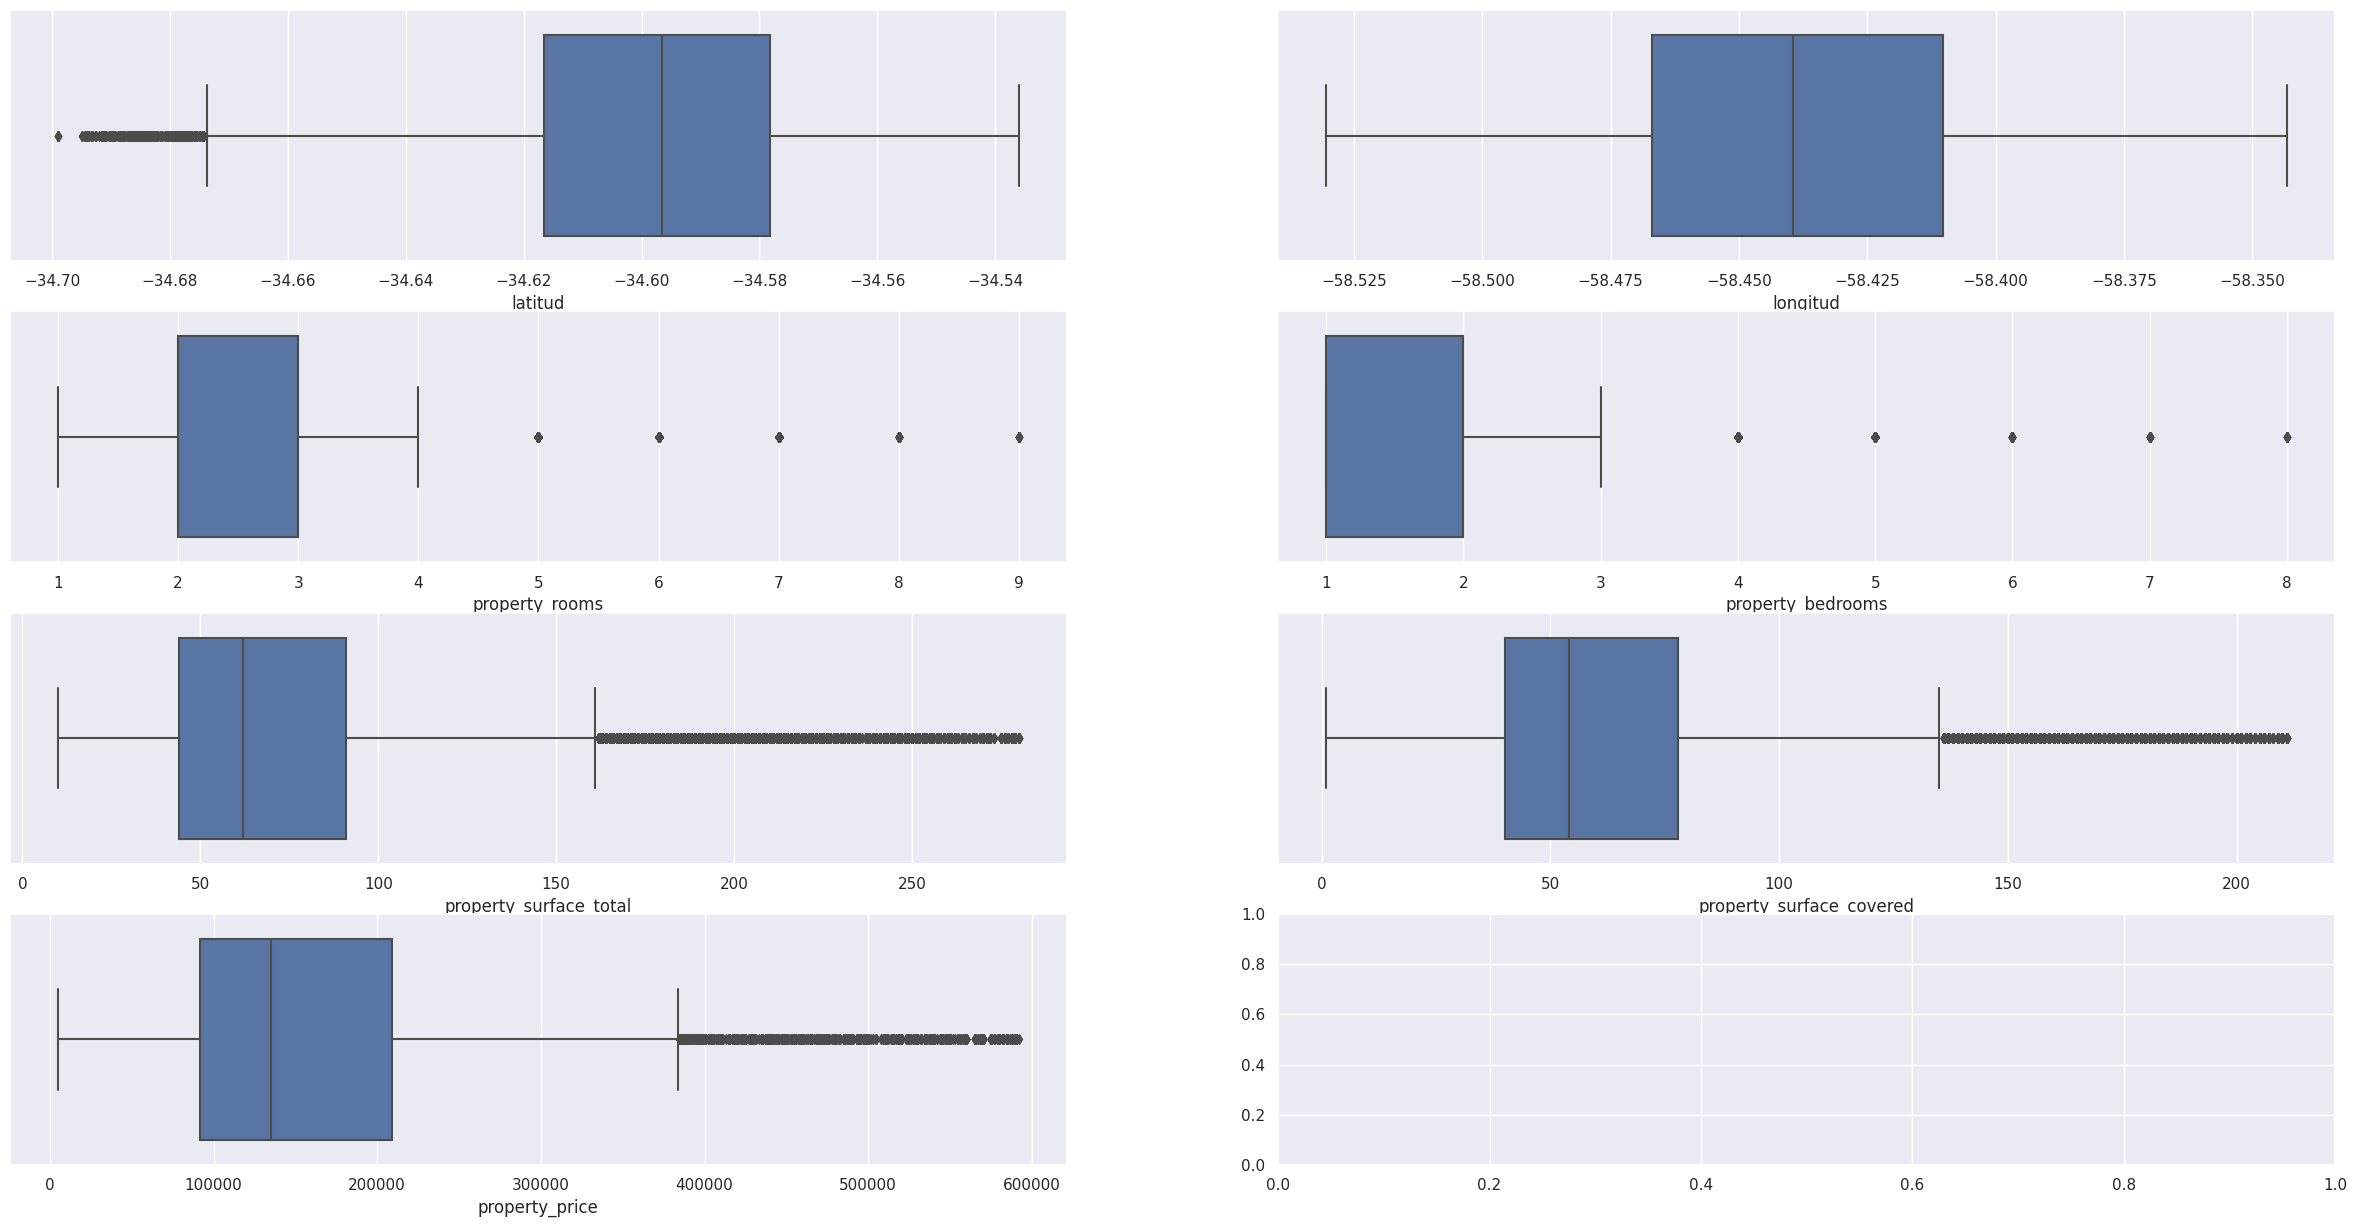

In [24]:
variables_cuantitativas = dataset_train[columnas_cuantitativas]

figs, axes = plt.subplots(nrows=4, ncols=2, figsize=(30, 15))
axes = np.ndarray.flatten(axes)
for (i, columna) in enumerate(variables_cuantitativas.columns):
    grafico = sns.boxplot(ax=axes[i], x=variables_cuantitativas[columna])
    grafico.set(xlabel=columna)


## Analisis de datos faltantes


Graficamos la distribucion de datos nulos

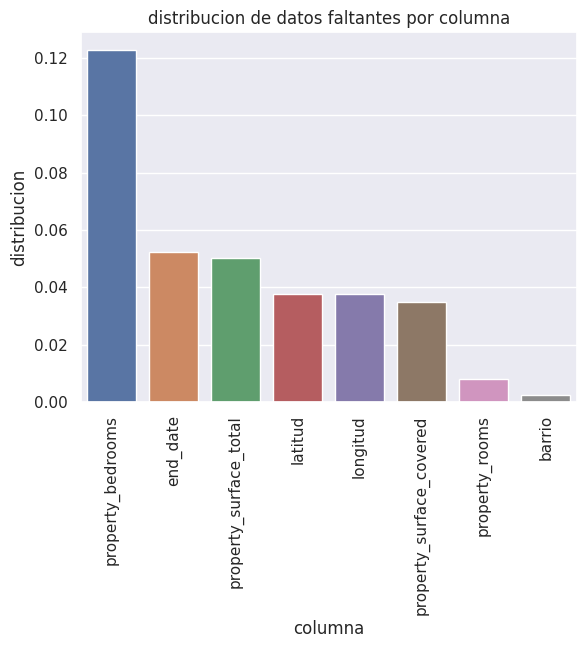

In [25]:
cantidad_de_datos_nulos_por_columna = dataset_train.isna().sum()
frecuencia_relativa = cantidad_de_datos_nulos_por_columna / dataset_train.shape[0]
frecuencia_relativa = frecuencia_relativa[frecuencia_relativa.values != 0]
frecuencia_relativa = frecuencia_relativa.sort_values(ascending=False)

ax = sns.barplot(x=frecuencia_relativa.index, y=frecuencia_relativa.values)
ax.set(
    title="distribucion de datos faltantes por columna",
    xlabel="columna",
    ylabel="distribucion",
)
ax.tick_params("x", labelrotation=90)


Graficamos la distribucion de cantidad de datos faltantes por fila. 

Vemos que la cantidad de filas con mas de 3 datos faltantes es minima


[Text(0.5, 0, 'Cantidad de datos faltantes por fila'),
 Text(0, 0.5, 'proporcion'),
 Text(0.5, 1.0, 'proporcion de datos faltantes por fila')]

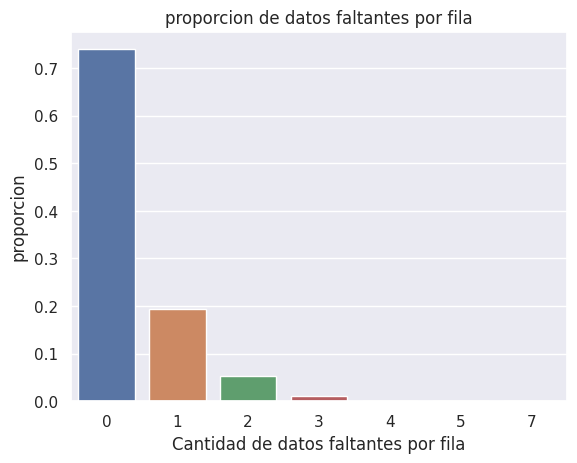

In [26]:
distribucion_faltantes_por_fila = (
    dataset_train.isna().sum(axis=1).value_counts() / dataset_train.shape[0]
)
ax = sns.barplot(
    x=distribucion_faltantes_por_fila.index,
    y=distribucion_faltantes_por_fila.values,
)
ax.set(
    xlabel="Cantidad de datos faltantes por fila",
    ylabel="proporcion",
    title="proporcion de datos faltantes por fila",
)


## Imputacion de datos faltante

Algunas estrategias para imputar los datos faltantes:

- Sustitución de Casos: Se reemplaza con valores no observados. Hay que consultar con un experto.
- Sustitución por Media: Se reemplaza utilizando la medida calculada de los valores presentes. Sin embargo, esto trae consecuencias
    - La varianza estimada por la nueva variable no es válida ya que es atenuada por los valores repetidos
    - Se distorsiona la distribución
    - Las correlaciones que se observen estaran deprimidas debido a la repetición de un solo valores constante.
- Imputación Cold Deck: Se pueden obtener los datos faltantes a partir de otras variables del dataset.
- Imputacion Hot Deck: Se reemplazan los datos faltante con los valores que resultan más “similares”. Tenemos que definir que es “similar”, para ello se puede usar la tecnica: K vecinos más cercanos.
- Imputación por Regresión: El dato faltante es reemplaza con el valor predicho por un modelo de regresión.
- MICE (multivariate imputation by chained equations): Trabaja bajo el supuesto de que el origen de los datos es MAR (missing at random). Es un proceso de imputación iterativo, donde cada iteración los valores faltantes se predicen en función de las variables restantes. El proceso se repite hasta que se encuentre consistencia en los datos (usualmente 10 iteraciones es suficiente). La primera iteración se realiza por uno de los métodos vistos anteriormente para rellenar los datos faltantes.

### Imputacion `property_bedrooms`, `property_rooms`, `property_price`

Anteriormente observamos que hay una correlacion entre `property_bedrooms`, `property_rooms` y `property_price`. Podemos entrenar un modelo lineal para predecir los datos faltantes

Imputamos los datos utilizando un imputador iterativo

In [27]:
columnas_a_imputar = ["property_bedrooms", "property_rooms", "property_price"]

modelo_lineal = LinearRegression()
imp = IterativeImputer(
    estimator=modelo_lineal,
    missing_values=np.nan,
    max_iter=20,
    random_state=SEMILLA,
)

columnas_imputadas = imp.fit_transform(dataset_train[columnas_a_imputar])

dataset_imputado = pd.DataFrame(columnas_imputadas, columns=columnas_a_imputar).astype(
    int
)


Observamos que tienen la misma distribución que los datos originales

[Text(0.5, 1.0, 'distribucion de precio de propiedad (imputado)'),
 Text(0.5, 0, 'precio de propiedad')]

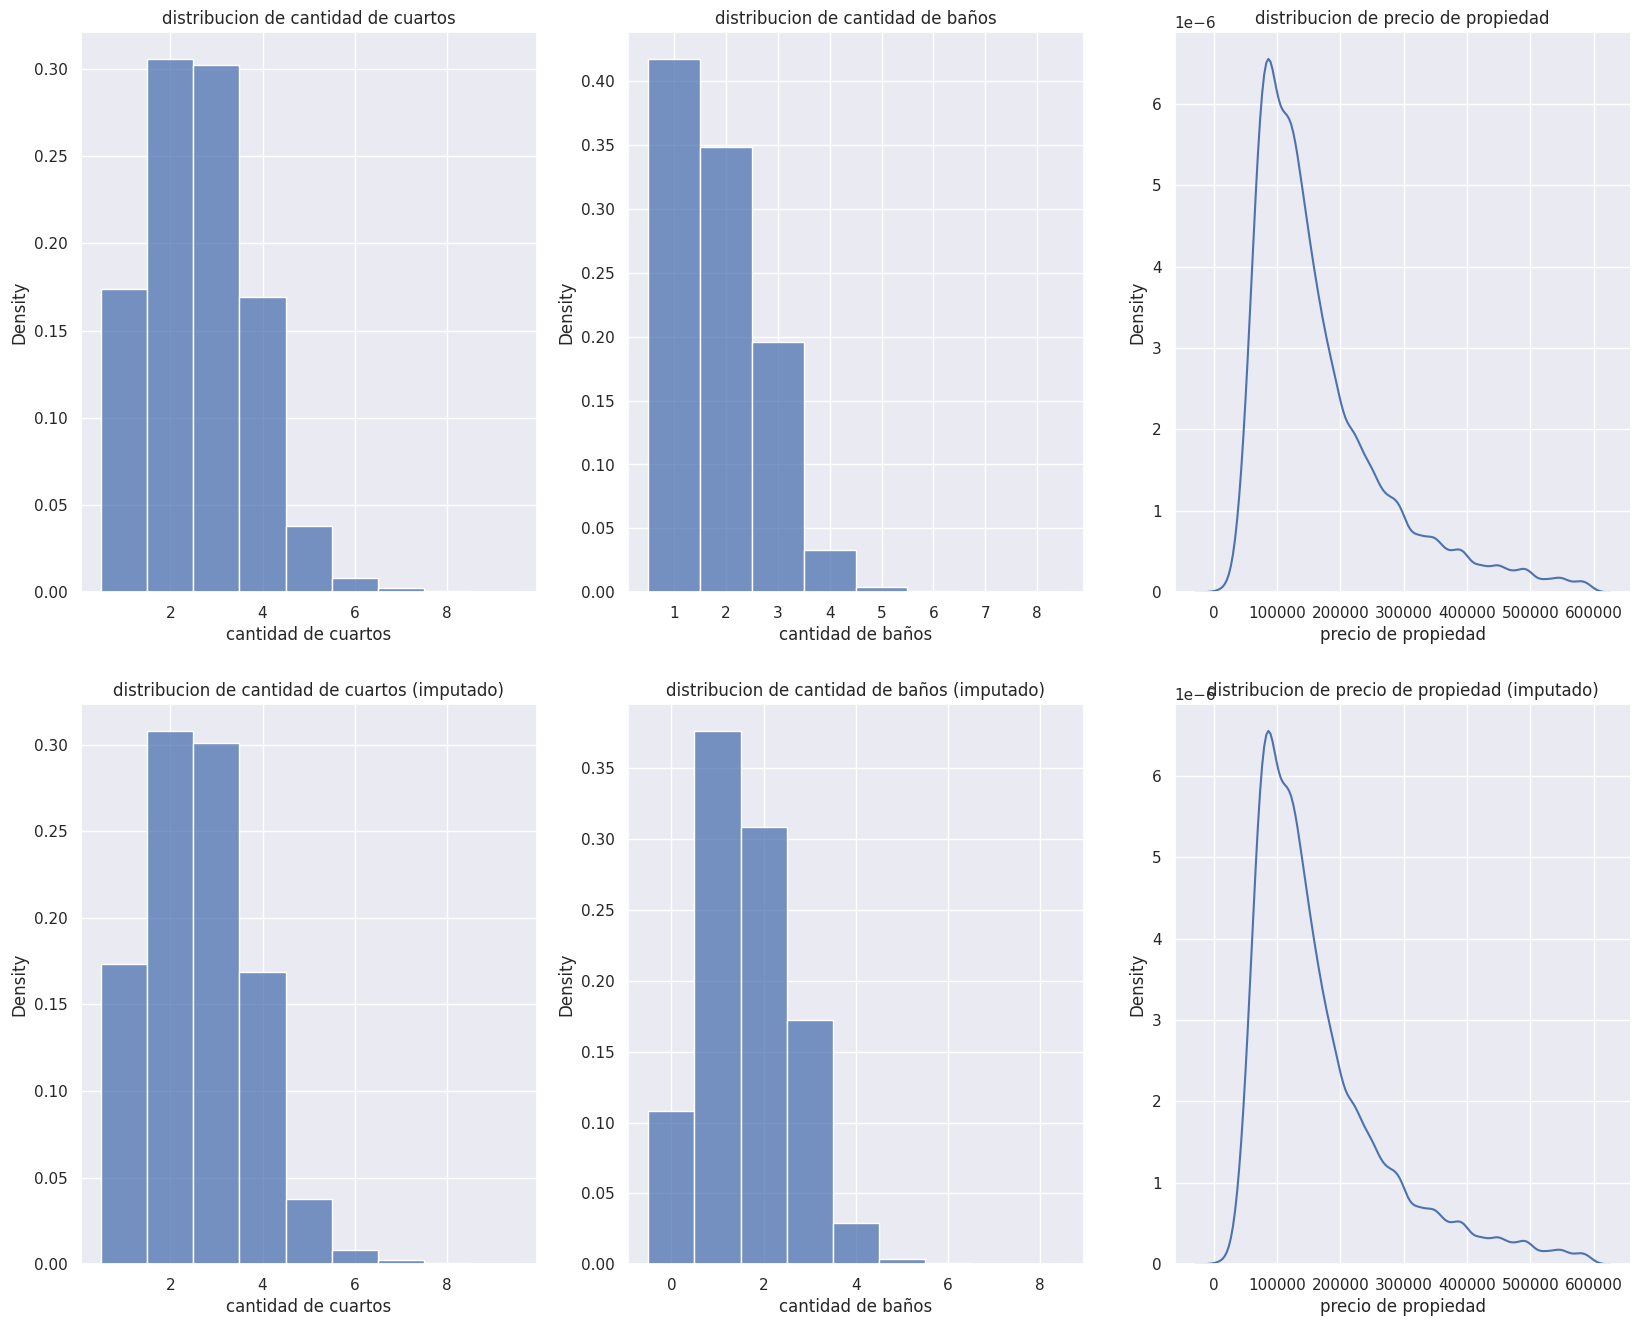

In [28]:
figs, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 16))

ax = sns.histplot(
    ax=axes[0][0], x=dataset_train.property_rooms, discrete=True, stat="density"
)
ax.set(title="distribucion de cantidad de cuartos", xlabel="cantidad de cuartos")

ax = sns.histplot(
    ax=axes[0][1], x=dataset_train.property_bedrooms, discrete=True, stat="density"
)
ax.set(title="distribucion de cantidad de baños", xlabel="cantidad de baños")

ax = sns.kdeplot(ax=axes[0][2], x=dataset_train.property_price)
ax.set(title="distribucion de precio de propiedad", xlabel="precio de propiedad")

ax = sns.histplot(
    ax=axes[1][0], x=dataset_imputado.property_rooms, discrete=True, stat="density"
)
ax.set(
    title="distribucion de cantidad de cuartos (imputado)", xlabel="cantidad de cuartos"
)

ax = sns.histplot(
    ax=axes[1][1], x=dataset_imputado.property_bedrooms, discrete=True, stat="density"
)
ax.set(title="distribucion de cantidad de baños (imputado)", xlabel="cantidad de baños")

ax = sns.kdeplot(ax=axes[1][2], x=dataset_imputado.property_price)
ax.set(
    title="distribucion de precio de propiedad (imputado)", xlabel="precio de propiedad"
)


Actualizamos los valores imputados en el nuevo dataframe

In [29]:
dataset_train[columnas_a_imputar] = dataset_imputado[columnas_a_imputar].values

dataset_train.isna().sum()


start_date                     0
end_date                    3637
created_on                     0
latitud                     2617
longitud                    2617
barrio                       155
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total      3503
property_surface_covered    2431
property_price                 0
dtype: int64

### Imputacion `property_surface_covered`, `property_surface_total`


Tambien observamos que hay una correlacion entre `property_surface_covered`, `property_surface_total`. Podemos entrenar otro modelo lineal para predecir estos datos faltantes

Imputamos los datos utilizando un imputador iterativo

In [30]:
columnas_a_imputar = ["property_surface_covered", "property_surface_total"]

modelo_lineal = LinearRegression()
imp = IterativeImputer(
    estimator=modelo_lineal,
    missing_values=np.nan,
    max_iter=20,
    verbose=0,
    random_state=SEMILLA,
)

columnas_imputadas = imp.fit_transform(dataset_train[columnas_a_imputar])

dataset_imputado = pd.DataFrame(columnas_imputadas, columns=columnas_a_imputar).astype(
    int
)


Observamos que tienen la misma distribución que los datos originales

[Text(0.5, 1.0, 'distribucion de superficie total (imputado)'),
 Text(0.5, 0, 'superficie total')]

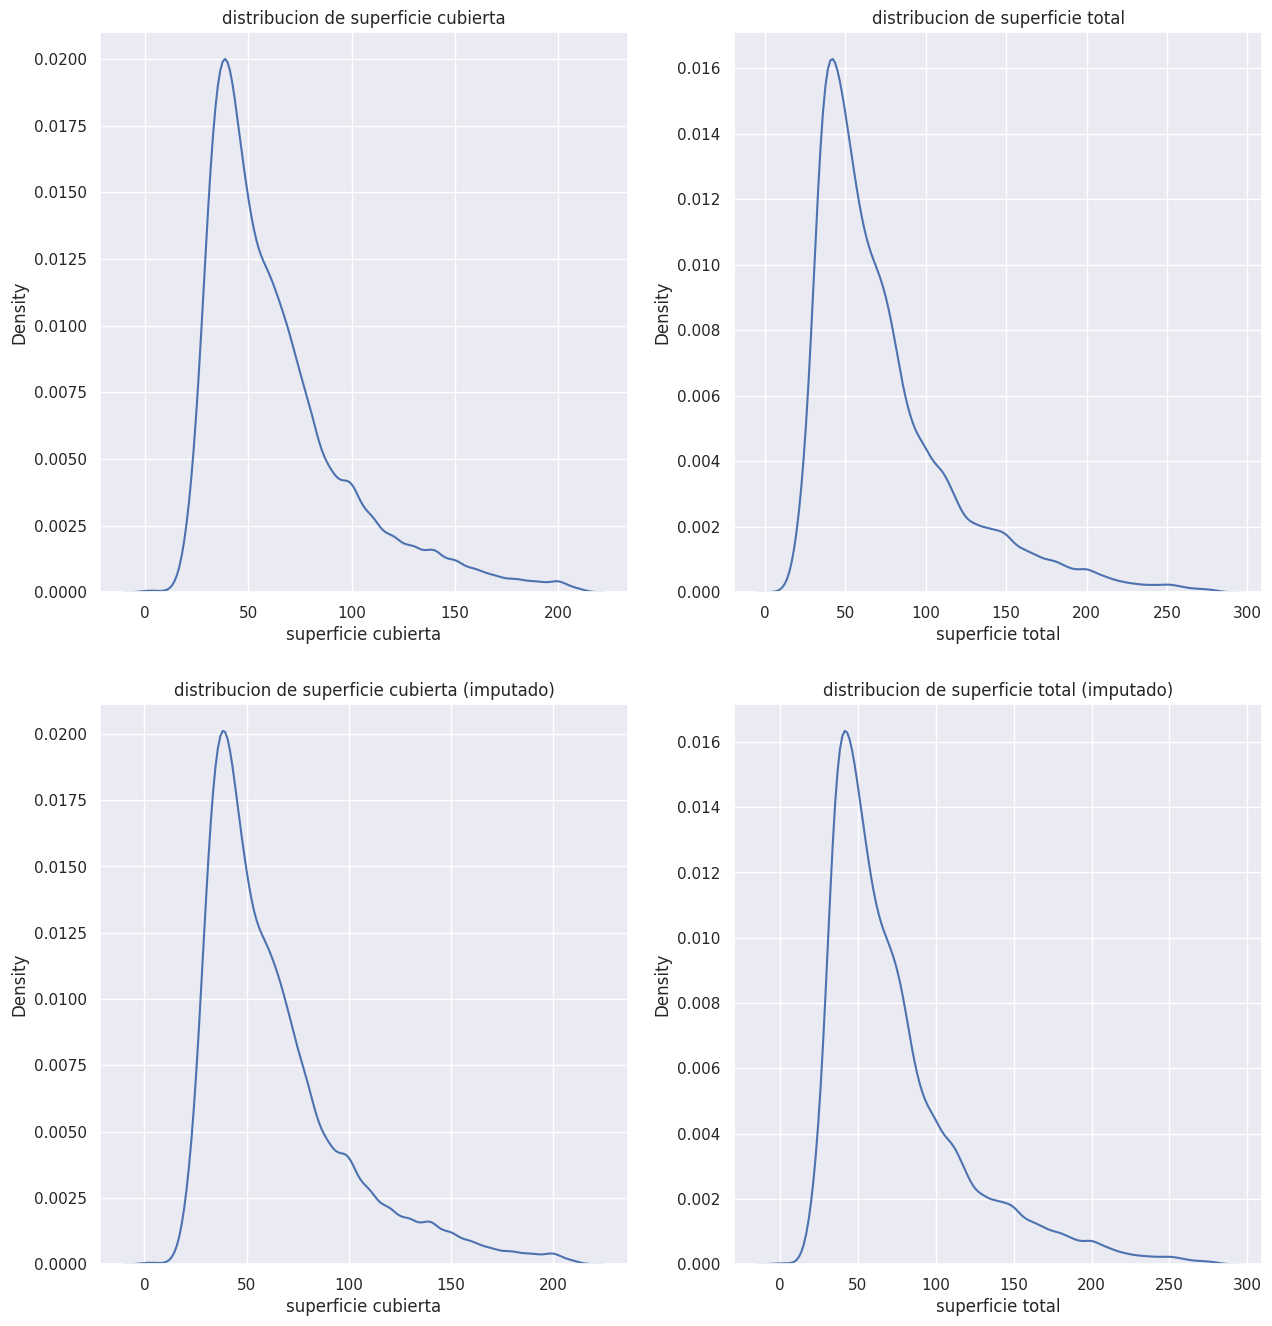

In [31]:
figs, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 16))

ax = sns.kdeplot(ax=axes[0][0], x=dataset_train.property_surface_covered)
ax.set(title="distribucion de superficie cubierta", xlabel="superficie cubierta")

ax = sns.kdeplot(ax=axes[0][1], x=dataset_train.property_surface_total)
ax.set(title="distribucion de superficie total", xlabel="superficie total")

ax = sns.kdeplot(ax=axes[1][0], x=dataset_imputado.property_surface_covered)
ax.set(
    title="distribucion de superficie cubierta (imputado)", xlabel="superficie cubierta"
)

ax = sns.kdeplot(ax=axes[1][1], x=dataset_imputado.property_surface_total)
ax.set(title="distribucion de superficie total (imputado)", xlabel="superficie total")


Actualizamos los valores imputados en el nuevo dataframe

In [32]:
dataset_train[columnas_a_imputar] = dataset_imputado[columnas_a_imputar].values

dataset_train.isna().sum()


start_date                     0
end_date                    3637
created_on                     0
latitud                     2617
longitud                    2617
barrio                       155
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total         0
property_surface_covered       0
property_price                 0
dtype: int64

Los datos faltantes de `end_date` no se van a quitar porque consideramos que representa que no se cerró el anuncio, y trabajaremos con esa información en mente.

### Imputacion de `latitud`, `longitud`, `barrio`

## Analisis de Valores Atípicos Multivariados

Una vez eliminados los valores atipicos univariados, trabajamos con los multivariados. Utilizando la distancia de Mahalanobis calcularemos la relación entre: `property_surface_total` y `property_surface_covered`; `property_price` y `property_surface_total`; `property_rooms` y `property_bedrooms` para analizar la existencia de outliers multivariados.

### `property_surface_total` con `property_surface_covered`

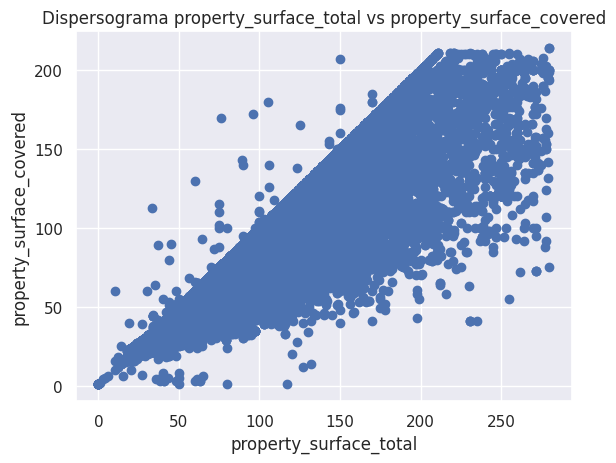

In [33]:
plt.scatter(dataset_train.property_surface_total,dataset_train.property_surface_covered)
plt.title('Dispersograma property_surface_total vs property_surface_covered')
plt.xlabel('property_surface_total')
plt.ylabel('property_surface_covered')
plt.show()

In [ ]:
#Conjunto de entrenamiento
X=dataset_train[['property_surface_total','property_surface_covered']].values

#Creo el clasificador
clf = LocalOutlierFactor(n_neighbors=20)

#Genero prediccion
y_pred = clf.fit_predict(X)

#Guardo los scores
scores=clf.negative_outlier_factor_

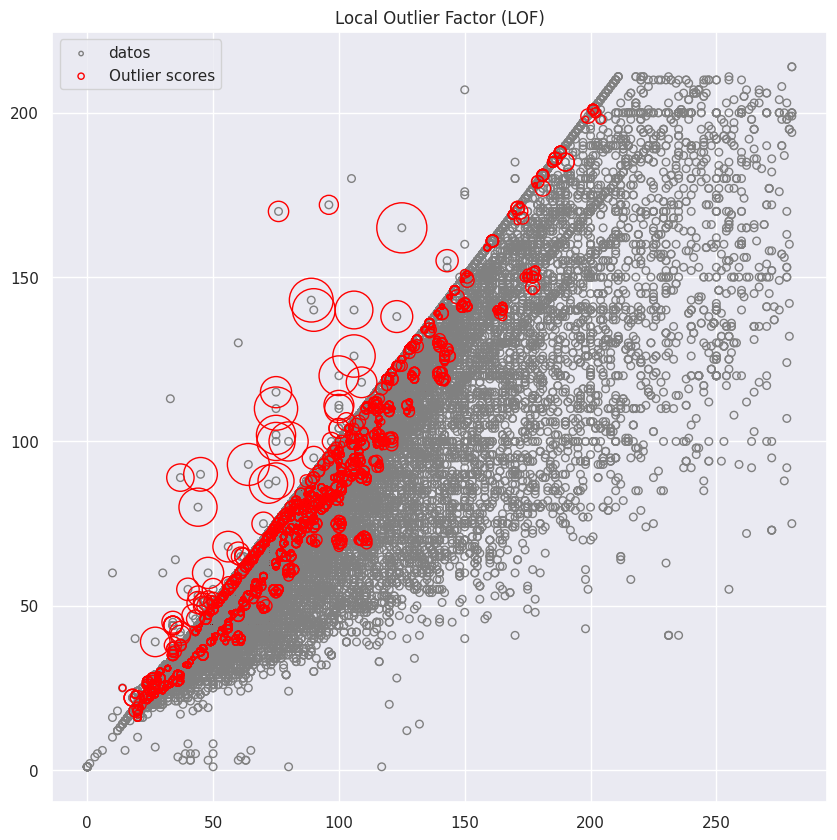

In [55]:
# Calculo radio para plotear score
radius = (scores.max() - dataset_train.scores1) / (
    dataset_train.scores1.max() - dataset_train.scores1.min()
)

# Grafico LOF
plt.figure(figsize=(10, 10))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(
    dataset_train.property_surface_total.values,
    dataset_train.property_surface_covered.values,
    edgecolor="grey",
    s=30,
    label="datos",
    facecolors="none",
)
plt.scatter(
    dataset_train.property_surface_total.values,
    dataset_train.property_surface_covered.values,
    s=1300 * radius,
    edgecolors="red",
    facecolors="none",
    label="Outlier scores",
)
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()


In [ ]:
#fijar umbral


In [ ]:
#scatter plot con distintos colores para outliers y datos normales

### `property_price` con `property_surface_total`

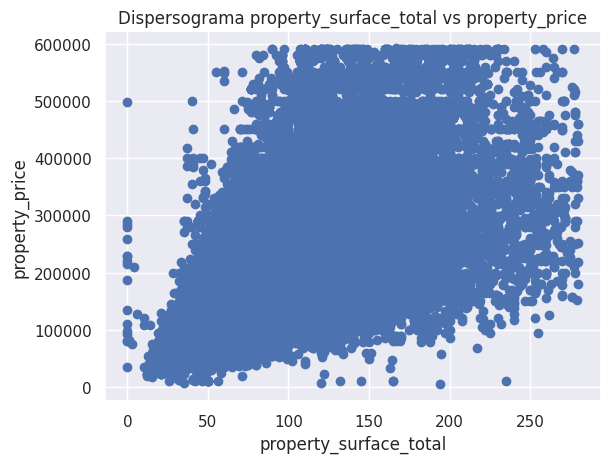

In [57]:
plt.scatter(dataset_train.property_surface_total,dataset_train.property_price)
plt.title('Dispersograma property_surface_total vs property_price')
plt.xlabel('property_surface_total')
plt.ylabel('property_price')
plt.show()

In [64]:
#Conjunto de entrenamiento
X=dataset_train[['property_price','property_surface_total']].values

#Creo el clasificador
clf = LocalOutlierFactor(n_neighbors=3)

#Genero prediccion
y_pred = clf.fit_predict(X)

#Guardo los scores
scores=clf.negative_outlier_factor_

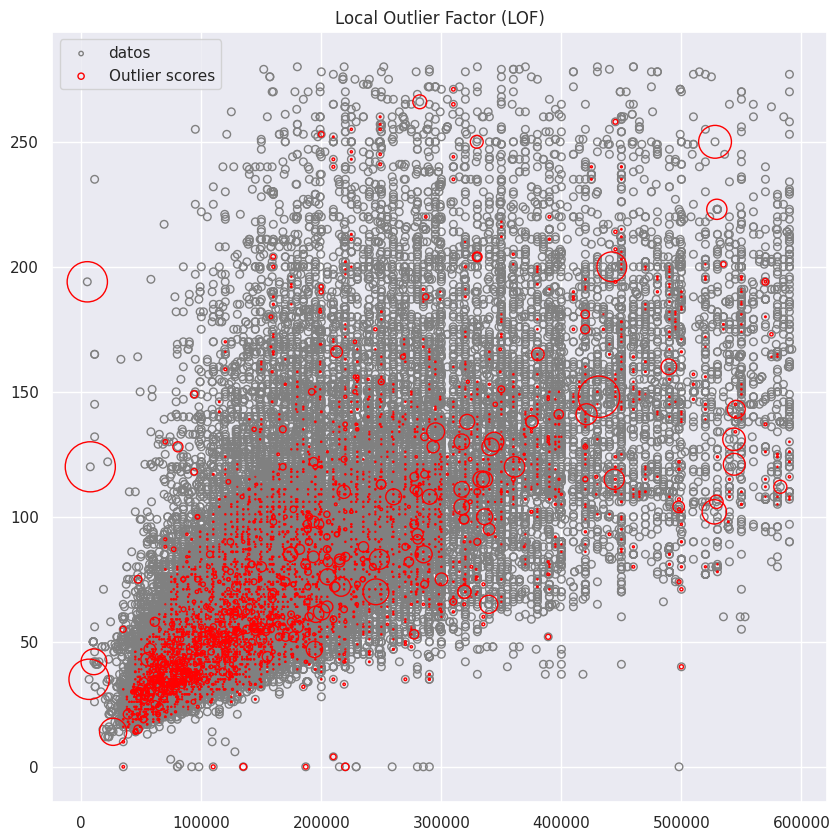

In [70]:
# Calculo radio para plotear score
radius = (scores.max() - scores) / (
    scores.max() - scores.min()
)

# Grafico LOF
plt.figure(figsize=(10, 10))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(
    dataset_train.property_price,
    dataset_train.property_surface_total.values,
    edgecolor="grey",
    s=30,
    label="datos",
    facecolors="none",
)
plt.scatter(
    dataset_train.property_price.values,
    dataset_train.property_surface_total.values,
    s=1300 * radius,
    edgecolors="red",
    facecolors="none",
    label="Outlier scores",
)
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

<AxesSubplot:>

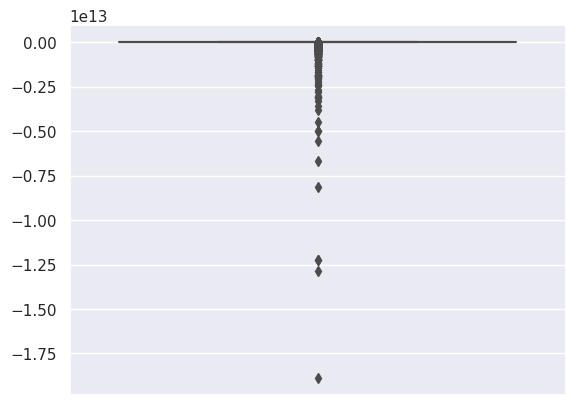

In [92]:
#boxplot para detectar umbral
sns.boxplot(y = scores)

In [90]:
#umbral
umbral = 0.1

es_outlier = radius < umbral

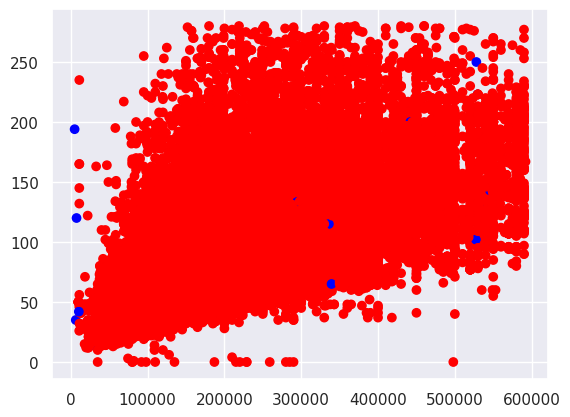

In [91]:

#[ expression for item in list if conditional ]
#[a if C else b for i in items]
filtrado_colores = ['red' if es else 'blue' for es in es_outlier]
plt.scatter(
    dataset_train.property_price.values,
    dataset_train.property_surface_total.values,
    c=filtrado_colores,
)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bc9b46f5-899c-4314-8e44-8f9e77759939' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>